# Typhoon Prediction Project
* Predict the trajectory of typhoons
    * 6h, 12h, 18h, 24h, ...
* LSTM, GRU

In [481]:
import pandas as pd
# from pandas.core.common import SettingWithCopyWarning
import numpy as np
import torch
from torch.utils.data import Dataset,DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import mean_absolute_error, f1_score
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import geopandas as gpd
from shapely.geometry import LineString
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

pd.set_option('mode.chained_assignment', None)
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    device = 'cpu'
    print('CUDA is not available. Training on CPU...')
else:
    device = 'cuda'

# Data PreProcessing

In [482]:
DIR_MAP = {'북': 0, '북동':1, '북서': 2, '북북서':3, '북북동':4, '서북서':5, '서':6, '서남서':7, '동북동':8, '남서':9,'남남동':10, '동남동':11, '남남서':12, '동':13, '남':14, '남동':15, -1:-1}

In [483]:
## 전처리
def rep_nan(data):
    data['진행방향'].fillna(-1, inplace = True)
def drop_str(data):
    cnt=0
    for y,m,d,t in zip(data["Year"],data["Month"],data["Date"],data["Time"]):
            data["Year"][cnt] = y.split("년")[0]
            data["Month"][cnt] = m.split("월")[0]
            data["Date"][cnt] = d.split("일")[0]
            data["Time"][cnt] = t.split("시")[0]
            cnt+=1
    return data
def str2int(data):
    data["Year"]=0
    data["Month"]=0
    data["Date"]=0
    data["Time"]=0
    for i, element in enumerate(data["일시"]):
        data["Year"][i]=element.split(' ')[0]
        data["Month"][i]=element.split(' ')[1]
        data["Date"][i]=element.split(' ')[2]
        data["Time"][i]=element.split(' ')[3]
    return data
def cat_1(data):
    strength_map={}
    for i, s in enumerate(data["강도"].unique()):
        strength_map[s] = i
    data["강도"] = data["강도"].map(strength_map)
    return data
def cat_2(data):
    for i, s in enumerate(data["크기"]):
        if s=="-":
            data["크기"][i] = 0
        elif s=="소형":
            data["크기"][i] = 1
        elif s=="중형":
            data["크기"][i] = 2
        else:
            data["크기"][i] = 3
    return data
def dir_enc(data):
    for i in range(len(data)):
        data["진행방향"][i] = DIR_MAP[data["진행방향"][i]]
def prepro(data):
    idx = data[data["Unnamed: 1"]!=0].index
    data = data.drop(idx)
    data = data.reset_index()
    data = str2int(data)
    drop_str(data)
    data =cat_1(data)
    data =cat_2(data)
    data = data.drop(["70% 확률 반경(km)", "Unnamed: 1","일시","index"], axis=1)
    rep_nan(data)
    dir_enc(data)
    return data
# def prepro2(data):
#     data = dir_enc(data)

In [484]:
data_dir = "C:/Lab/Capstone/Typhoon/tp_"
data = []

In [485]:
## csv 순서대로읽어와서 data에 저장
for i in range(1,529):
    data.append(pd.read_csv(data_dir+str(i).zfill(3)+".csv",encoding_errors='ignore',encoding="cp949"))

In [486]:
Hin = data[521]
Megi = data[512]
del(data[521])
del(data[512])

In [487]:
for i in range(len(data)):
    data[i]=prepro(data[i])
    #data[i].insert(0,'ID', i)
Hin = prepro(Hin)
Megi = prepro(Megi)


In [488]:
for i in range(len(data)):
    data[i] = data[i].drop(["Year","Month","Date","Time"],axis=1)
Hin = Hin.drop(["Year","Month","Date","Time"],axis=1)
Megi = Megi.drop(["Year","Month","Date","Time"],axis=1)

In [489]:
for i in range(len(data)):
    data[i] = data[i].fillna(0)

In [490]:
minmax = {}
for j in ['위도(N)','경도(E)','중심기압','초속(m/s)','시속(km/h)','강풍반경(km)[예외반경]','이동속도(km/h)']:
    m = np.inf
    M = -np.inf
    for i in range(len(data)):
        m = m if np.min(data[i][[j]].values) > m else np.min(data[i][[j]].values)
        # if m == -1 :
            # print(i, end = ' ')
    for i in range(len(data)):
        M = M if np.max(data[i][[j]].values) < M  else np.max(data[i][[j]].values)
    minmax[j] = [m,M]
    print('min', m)
    print('max', M)

min 1.6
max 54.0
min 99.8
max 180.0
min 0
max 1010
min -1
max 61
min -4
max 220
min 0
max 1480.0
min 0.0
max 216


In [491]:
minmax['위도(N)'][0], minmax['위도(N)'][1] = 0, 60
minmax['경도(E)'][0], minmax['경도(E)'][1] = 90, 180

for i in range(len(data)):
    for j in ['위도(N)','경도(E)','중심기압','초속(m/s)','시속(km/h)','강풍반경(km)[예외반경]','이동속도(km/h)']:
        data[i][j] = (data[i][j] - minmax[j][0])/(minmax[j][1] - minmax[j][0])

In [492]:
len(data)

526

In [493]:
data[0]

,위도(N),경도(E),중심기압,초속(m/s),시속(km/h),강풍반경(km)[예외반경],강도,크기,진행방향,이동속도(km/h)
0,0.300000,0.323333,0.986139,0.306452,0.308036,0.121622,0,1,0,0.069444
1,0.323333,0.340000,0.982178,0.387097,0.388393,0.189189,0,1,1,0.055556
2,0.368333,0.363333,0.980198,0.387097,0.388393,0.222973,0,2,1,0.138889


# Dataloader

## Window DataSet

In [494]:
class windowDataset(Dataset):
    def __init__(self, data, input_window, output_window,
                 in_features = ['중심기압','초속(m/s)','시속(km/h)','강풍반경(km)[예외반경]','강도','크기','진행방향','이동속도(km/h)'],
                 out_features = ['위도(N)','경도(E)'], stride=1):
        deletion = []
        num_samples = 0
        
        #총 데이터의 개수
        #inputwindow + outputwindow 보다 짧은 길이의 태풍들은 데이터에서 제거해줌.
        for i, d in enumerate(data):
            if(len(d) < input_window + output_window):
                deletion.append(i)
                continue
            #stride씩 움직일 때 생기는 총 sample의 개수
            #태풍별로 확인해줄 예정이니 각 태풍마다의 sample개수를 구하여 전부 더해줌.
            num_samples += (len(d) - input_window - output_window) // stride + 1
        print('number of useable data : ', len(data)-len(deletion))
        for i in deletion[::-1]:
            del data[i]
        #in feature의 개수와 out feature의 개수 저장
        num_in_feature = len(in_features)
        num_out_feature = len(out_features)

        #input과 output : shape = (window 크기, sample 개수, feature 개수)
        X = np.zeros([input_window, num_samples, num_in_feature])
        Y = np.zeros([input_window + output_window, num_samples, num_out_feature])

        j = 0
        for d in data:
            #data별로 불러옴
            for i in range((len(d) - (input_window + output_window))// stride + 1):
                #각 데이터의 길이를 확인하고 각 데이터별로 input_window와 output_window에따른
                #활용가능한 학습용 데이터의 길이를 확인함
                #각 태풍별로 input_window와 output_window에 따른 학습용 데이터를 추출함.
                start_x = stride*i
                end_x = start_x + input_window
                X[:,j] = d[start_x:end_x][in_features]
                
                start_y = stride*i
                end_y = start_y +input_window + output_window
                Y[:,j] = d[start_y:end_y][out_features]
                j += 1

        #추출한 데이터를 Dataset 형식에 맞추어 reshape
        X = X.reshape(X.shape[0], X.shape[1], num_in_feature).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], num_out_feature).transpose((1,0,2))
        self.x = X.astype(np.float32)
        self.y = Y.astype(np.float32)
        
        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len

In [495]:
# class Windowdataset(Dataset):
#     def __init__(self, data, y, input_wd, output_wd, stride=1):
#         # self.data = data
#         # self.target = y
#         n_data = len(y)
#         window_data = (n_data - input_wd - output_wd) // stride + 1
        
#         X = np.zeros([input_wd, n_data])
#         Y = np.zeros([output_wd, n_data])
        
#         for i in np.arange(n_data):
#             start_x = stride * i
#             end_x = start_x + input_wd
#             X[:, i] = Y[start_x:end_x]
            
#             start_y = stride*i + input_wd
#             end_y = start_y + output_wd
#             Y[:,i] = y[start_y:end_y]
#         X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
#         Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        
#         self.data = X
#         self.target = Y
#     def __len__(self):
#         return len(self.data)
        
#     def __getitem__(self, i):
#         return self.data[i], self.target[i]

In [496]:
len(data)

526

In [497]:
val_idx, test_idx

(473, 499)

In [498]:
in_window=4
out_window=2
batch_size = 128

val_idx = int(len(data)*0.9)
test_idx = int(len(data)*0.95)
train_data, valid_data, test_data = data[:val_idx], data[val_idx:test_idx], data[test_idx:]

train_dataset = windowDataset(train_data,in_window,out_window)
valid_dataset = windowDataset(valid_data,in_window,out_window)
test_dataset = windowDataset(test_data, in_window,out_window)

train_loader = DataLoader(train_dataset, batch_size, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, 1 , shuffle=False)

number of useable data :  408
number of useable data :  23
number of useable data :  24


In [499]:
next(iter(train_loader))[0].shape,next(iter(valid_loader))[0].shape,next(iter(test_loader))[0].shape

(torch.Size([128, 4, 8]), torch.Size([128, 4, 8]), torch.Size([1, 4, 8]))

In [500]:
next(iter(train_loader))[1][0]

tensor([[0.2183, 0.4778],
        [0.2517, 0.4122],
        [0.3250, 0.3589],
        [0.3683, 0.3278],
        [0.4133, 0.3267],
        [0.4417, 0.3278]])

## Model

In [533]:
input_size = 8
hidden_size =100
num_layer = 2
output_size = 2

## Bidirectional

In [534]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size,num_layer,batch_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.batch_size = batch_size
        self.num_layer = num_layer
        self.gru = nn.GRU(input_size, hidden_size,num_layer, batch_first=True,bidirectional=True)
        
        self.ln = nn.LayerNorm(hidden_size)
         
        self.dropout= nn.Dropout(0.3)
        
    def forward(self, input, hidden):
        
        output, hidden = self.gru(input, hidden)

        hidden = self.ln(hidden)

        return output, hidden
        
    def initHidden(self,num_layer,batch_size):
        return torch.zeros(2*num_layer,batch_size,self.hidden_size)

In [535]:
class DecoderRNN(nn.Module):
    def __init__(self, output_size, hidden_size, num_layer, batch_size):
        super(DecoderRNN, self).__init__()
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.num_layer = num_layer
        
        self.gru = nn.GRU(output_size, hidden_size,num_layer, batch_first=True)
        
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        
        self.fc2 = nn.Linear(hidden_size, output_size)
        
        self.ln = nn.LayerNorm(hidden_size)
        
        self.relu = nn.ReLU(True)
        
        self.dropout = nn.Dropout(0.3)
        
        self.bn = nn.InstanceNorm1d(hidden_size)
        
        self.bn = nn.BatchNorm1d(output_size)
        
    def forward(self, input, hidden):
        
        output, hidden = self.gru(input, hidden)
        
        # hidden = self.dropout(hidden)
        
        hidden = self.ln(hidden)
        
        output = self.ln(output)
        
        # output = self.dropout(output)
        
        output = self.relu(self.fc1(output))
        
        # output = self.dropout(output)
        
        output = self.fc2(output)
        
        # output = self.relu(output)
        
        return output, hidden
    
    def initHidden(self, num_layer, batch_size):
        return torch.zeros(num_layer,batch_size,self.hidden_size)

In [511]:
a = torch.ones((2,128,32))

In [512]:
torch.concat((a,a),dim=0).shape

torch.Size([4, 128, 32])

In [513]:
a.max(dim=(0))[0].shape

torch.Size([128, 32])

### Encoder

In [536]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size,num_layer,batch_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.batch_size = batch_size
        self.num_layer = num_layer
        self.gru = nn.GRU(input_size, hidden_size,num_layer, batch_first=True)
        
        self.ln = nn.LayerNorm(hidden_size)
         
        self.dropout= nn.Dropout(0.3)
        
    def forward(self, input, hidden):
        
        output, hidden = self.gru(input, hidden)

        hidden = self.ln(hidden)

        return output, hidden
        
    def initHidden(self,num_layer,batch_size):
        return torch.zeros(num_layer,batch_size,self.hidden_size)

### Decoder

In [540]:
class DecoderRNN(nn.Module):
    def __init__(self, output_size, hidden_size, num_layer, batch_size):
        super(DecoderRNN, self).__init__()
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.num_layer = num_layer
        
        self.gru = nn.GRU(output_size, hidden_size,num_layer, batch_first=True)
        
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        
        self.fc2 = nn.Linear(hidden_size, output_size)
        
        self.ln = nn.LayerNorm(hidden_size)
        
        self.relu = nn.ReLU(True)
        
        self.dropout = nn.Dropout(0.3)
        
        self.bn = nn.InstanceNorm1d(hidden_size)
        
        # self.bn = nn.BatchNorm1d(output_size)
        
    def forward(self, input, hidden):
        
        output, hidden = self.gru(input, hidden)
        
        # hidden = self.dropout(hidden)
        
        hidden = self.ln(hidden)
        
        output = self.ln(output)
        
        # output = self.dropout(output)
        
        output = self.relu(self.fc1(output))
        
        output = self.dropout(output)
        
        output = self.fc2(output)
        
        # output = self.relu(output)
        
        return output, hidden
    
    def initHidden(self, num_layer, batch_size):
        return torch.zeros(num_layer,batch_size,self.hidden_size)

In [541]:
encoder = EncoderRNN(input_size, hidden_size, num_layer, batch_size)
decoder = DecoderRNN(output_size, hidden_size, num_layer, batch_size)
encoder, decoder

(EncoderRNN(
   (gru): GRU(8, 100, num_layers=2, batch_first=True)
   (ln): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
   (dropout): Dropout(p=0.3, inplace=False)
 ),
 DecoderRNN(
   (gru): GRU(2, 100, num_layers=2, batch_first=True)
   (fc1): Linear(in_features=100, out_features=100, bias=True)
   (fc2): Linear(in_features=100, out_features=2, bias=True)
   (ln): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
   (relu): ReLU(inplace=True)
   (dropout): Dropout(p=0.3, inplace=False)
   (bn): InstanceNorm1d(100, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
 ))

## Model Training

In [542]:
epoch = 500
teacher_forcing_ratio = 0.5
learning_rate = 0.006
# embeder = Emb(hidden_size, output_size)
encoder.to(device)
decoder.to(device)
# embeder.to(device)
encoder_optimizer = optim.Adam(encoder.parameters(), lr = learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr = learning_rate)
# embeder_optimizer = optim.Adam(embeder.parameters(), lr = learning_rate)
# scheduler1 = optim.lr_scheduler.StepLR(encoder_optimizer,step_size=100,verbose=True)
# scheduler2 = optim.lr_scheduler.StepLR(decoder_optimizer,step_size=100,verbose=True)

# criterion = mse_loss
criterion = nn.MSELoss()
# Save training loss
train_loss = torch.zeros(epoch)
valid_loss_min = np.Inf
# Save validation loss
valid_loss = torch.zeros(epoch)
for e in trange(epoch):
    encoder.train()
    decoder.train()
    for data, label in train_loader:
        data, label = data.to(device), label.to(device)

        encoder_hidden = encoder.initHidden(num_layer,label.shape[0])
        encoder_hidden = encoder_hidden.to(device)
        
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        # embeder_optimizer.zero_grad()
        encoder_length = data.size(1) # input_window_size
        decoder_length = label.size(1) # input_window_size + output_window_size
        
        # encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_size).to(device)
        
        
        # Encoder
        for ei in range(encoder_length): #input_window_size 만큼
            encoder_output, encoder_hidden = encoder(data[:,ei,:].reshape(label.shape[0],1,-1), encoder_hidden)
        # Decoder_init
        d_input = torch.zeros((label.shape[0],1,2)).to(device)
        # d_input = label[:,0,:].reshape(label.shape[0],1,-1)
        decoder_input = d_input
        decoder_hidden = encoder_hidden
        
        # Decoder
        for di in range(decoder_length): # input_window_size + output_window_size 만큼
            decoder_output, decoder_hidden = decoder(decoder_input,decoder_hidden)
            loss=criterion(decoder_output, label[:,di,:].reshape(label.shape[0],1,-1))
            decoder_input = label[:,di,:].reshape(label.shape[0],1,-1) #if teacher_force else decoder_output
            train_loss[e] += loss.item()
            
        loss.backward(retain_graph = True)
        encoder_optimizer.step()
        decoder_optimizer.step()
    train_loss[e] /= len(train_loader)

    with torch.no_grad():
        encoder.eval()
        decoder.eval()
        for data, label in valid_loader:
            data, label = data.to(device), label.to(device)
            
            encoder_hidden = encoder.initHidden(num_layer,label.shape[0])
            encoder_hidden = encoder_hidden.to(device)

            encoder_length = data.size(1)
            decoder_length = label.size(1)

            # Encoder
            for ei in range(encoder_length):
                encoder_output, encoder_hidden = encoder(data[:,ei,:].reshape(label.shape[0],1,-1), encoder_hidden)
            # Decoder_init
            d_input = torch.zeros((label.shape[0],1,2)).to(device)
            # d_input = label[:,0,:].reshape(label.shape[0],1,-1)
            decoder_input = d_input
            decoder_hidden = encoder_hidden
            
            # Decoder
            for di in range(decoder_length):
                decoder_output, decoder_hidden = decoder(decoder_input,decoder_hidden)
                decoder_input = label[:,di,:].reshape(label.shape[0],1,-1)
                loss=criterion(decoder_output, label[:,di,:].reshape(label.shape[0],1,-1))
                valid_loss[e] += loss.item()
        valid_loss[e] /= len(valid_loader)
        # scheduler1.step()
        # scheduler2.step()
    print(f'Epoch : {e},\ttrain_loss : {train_loss[e]}\tvalid_loss :{valid_loss[e]}')
    if (valid_loss[e] < valid_loss_min):
        print(f'**********Valid loss decreased ({valid_loss_min:.6f} ==> {valid_loss[e]:.6f})**********')
        valid_loss_min = valid_loss[e]
        torch.save(encoder.state_dict(),'Encoder.pt')
        torch.save(decoder.state_dict(),'Decoder.pt')

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch : 0,	train_loss : 0.3947237730026245	valid_loss :0.14449597895145416
**********Valid loss decreased (inf ==> 0.144496)**********
Epoch : 1,	train_loss : 0.16097933053970337	valid_loss :0.11230559647083282
**********Valid loss decreased (0.144496 ==> 0.112306)**********
Epoch : 2,	train_loss : 0.149897962808609	valid_loss :0.10876945406198502
**********Valid loss decreased (0.112306 ==> 0.108769)**********
Epoch : 3,	train_loss : 0.14411912858486176	valid_loss :0.1027689278125763
**********Valid loss decreased (0.108769 ==> 0.102769)**********
Epoch : 4,	train_loss : 0.1390744298696518	valid_loss :0.10753384232521057
Epoch : 5,	train_loss : 0.13105307519435883	valid_loss :0.12926225364208221
Epoch : 6,	train_loss : 0.12686441838741302	valid_loss :0.08005417138338089
**********Valid loss decreased (0.102769 ==> 0.080054)**********
Epoch : 7,	train_loss : 0.12235046178102493	valid_loss :0.07996315509080887
**********Valid loss decreased (0.080054 ==> 0.079963)**********
Epoch : 8,	t

## Test & Eval

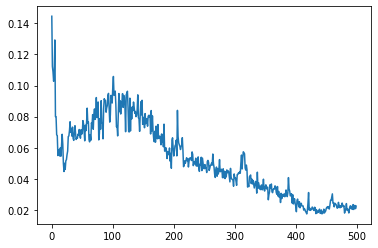

In [543]:
plt.plot(valid_loss)

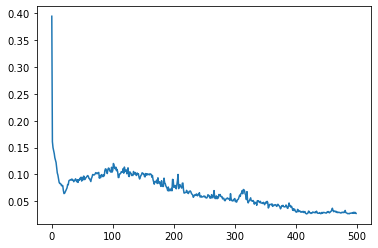

In [544]:
plt.plot(train_loss)

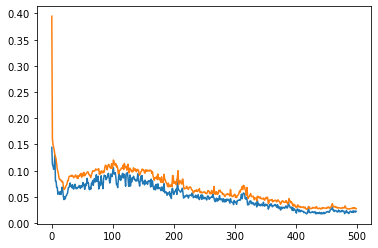

In [545]:
plt.plot(valid_loss)
plt.plot(train_loss)

In [546]:
encoder.load_state_dict(torch.load('./Encoder_wbest.pt'))
decoder.load_state_dict(torch.load('./Decoder_wbest.pt'))
encoder.eval()
decoder.eval()

DecoderRNN(
  (gru): GRU(2, 100, num_layers=2, batch_first=True)
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
  (ln): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (relu): ReLU(inplace=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (bn): InstanceNorm1d(100, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
)

In [549]:
test_data_1 = next(iter(train_loader))[0][1,:,:]
test_label_1 = next(iter(train_loader))[1][1,:,:]
test_data_1 = test_data_1.reshape(1,4,-1)
test_label_1 = test_label_1.reshape(1,6,-1)
test_data_2 = next(iter(train_loader))[0][2,:,:]
test_label_2 = next(iter(train_loader))[1][2,:,:]
test_data_2 = test_data_2.reshape(1,4,-1)
test_label_2 = test_label_2.reshape(1,6,-1)
test_data_3 = next(iter(train_loader))[0][3,:,:]
test_label_3 = next(iter(train_loader))[1][3,:,:]
test_data_3 = test_data_3.reshape(1,4,-1)
test_label_3 = test_label_3.reshape(1,6,-1)

## First_input = Zeros

In [552]:
test_data_1 = test_data_1.to(device)
hid = encoder.initHidden(2,1)
hid = hid.to(device)
pred_path = []
for i in range(in_window):
    out, hidden = encoder(test_data_1[:,i,:].reshape(1,1,-1), hid)
d_input = torch.zeros((1,1,2)).to(device)
# d_input = test_label_1[:,0,:].reshape(1,1,-1).to(device)
decoder_input = d_input
decoder_hidden = hidden

for i in range(in_window):
    decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
    decoder_input = test_label_1[:,i,:].reshape(1,1,-1).to(device)
    pred_path.append(decoder_input)
    
for i in range(out_window):
    decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
    decoder_input = decoder_output
    pred_path.append(decoder_output)


In [551]:
pred_path, test_label_1

([tensor([[[0.2517, 0.4122]]], device='cuda:0'),
  tensor([[[0.3250, 0.3589]]], device='cuda:0'),
  tensor([[[0.3683, 0.3278]]], device='cuda:0'),
  tensor([[[0.4133, 0.3267]]], device='cuda:0'),
  tensor([[[0.4595, 0.3485]]], device='cuda:0', grad_fn=<ViewBackward0>),
  tensor([[[0.4993, 0.3918]]], device='cuda:0', grad_fn=<ViewBackward0>)],
 tensor([[[0.2517, 0.4122],
          [0.3250, 0.3589],
          [0.3683, 0.3278],
          [0.4133, 0.3267],
          [0.4417, 0.3278],
          [0.4700, 0.3400]]]))

## TEST

In [561]:
tx = next(iter(test_loader))[0].to(device)
ty = next(iter(test_loader))[1].to(device)

In [562]:
hid = encoder.initHidden(2,1)
hid = hid.to(device)
pred_path = []
for i in range(in_window):
    out, hidden = encoder(tx[:,i,:].reshape(1,1,-1), hid)
d_input = torch.zeros((1,1,2)).to(device)
# d_input = test_label_1[:,0,:].reshape(1,1,-1).to(device)
decoder_input = d_input
decoder_hidden = hidden

for i in range(in_window):
    decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
    decoder_input = ty[:,i,:].reshape(1,1,-1).to(device)
    pred_path.append(decoder_input)
    
for i in range(out_window):
    decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
    decoder_input = decoder_output
    pred_path.append(decoder_output)


In [563]:
pred_path

[tensor([[[0.5417, 0.6433]]], device='cuda:0'),
 tensor([[[0.5550, 0.6467]]], device='cuda:0'),
 tensor([[[0.5750, 0.6511]]], device='cuda:0'),
 tensor([[[0.5900, 0.6567]]], device='cuda:0'),
 tensor([[[0.6002, 0.6506]]], device='cuda:0', grad_fn=<ViewBackward0>),
 tensor([[[0.5978, 0.6315]]], device='cuda:0', grad_fn=<ViewBackward0>)]

In [564]:
ty

tensor([[[0.5417, 0.6433],
         [0.5550, 0.6467],
         [0.5750, 0.6511],
         [0.5900, 0.6567],
         [0.6067, 0.6778],
         [0.6133, 0.6989]]], device='cuda:0')